# Brain tumor classification and detection using Keras and LIME


## Preprocess data
First we import all the necessary libraries:

In [1]:
import os
import cv2
import imutils
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
GAUSSIAN_BLUR_SIZE = (5, 5)
THRESHOLD = 20
ERODE_ITERATIONS = 2
DILATE_ITERATIONS = 2
KERNEL = np.ones((3, 3), np.uint8)
EXTRA_SPACE = 0
RESULT_PATH = "./preprocessed_dataset"
SOURCE_PATH = "./brain_tumor_dataset"

Then we define a function used to crop only the brain shape from the MRI:

In [3]:
def crop_image(image_name, result_name):
    img = cv2.imread(image_name)
    greyscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred_img = cv2.GaussianBlur(greyscale_img, GAUSSIAN_BLUR_SIZE, 0)
    threshold_img = cv2.threshold(blurred_img, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
    eroded_img = cv2.erode(threshold_img, KERNEL, iterations=ERODE_ITERATIONS)
    dilated_img = cv2.dilate(eroded_img, KERNEL, iterations=DILATE_ITERATIONS)
    contours = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    max_contour = max(contours, key=cv2.contourArea)
    left_point = max(min(max_contour[:, :, 0])[0] - EXTRA_SPACE, 0)
    right_point = min(max(max_contour[:, :, 0])[0] + EXTRA_SPACE, len(img[0]))
    top_point = max(min(max_contour[:, :, 1])[0] - EXTRA_SPACE, 0)
    bottom_point = min(max(max_contour[:, :, 1])[0] + EXTRA_SPACE, len(img))
    result_img = img[top_point:bottom_point, left_point:right_point]
    cv2.imwrite(result_name, result_img)

Now we need to create the result directories and save the cropped pictures there:

In [4]:
if not os.path.exists(f'{RESULT_PATH}'):
    os.makedirs(f'{RESULT_PATH}')
if not os.path.exists(f'{RESULT_PATH}/yes'):
    os.makedirs(f'{RESULT_PATH}/yes')
if not os.path.exists(f'{RESULT_PATH}/no'):
    os.makedirs(f'{RESULT_PATH}/no')

In [5]:
for directory in os.listdir(SOURCE_PATH):
    images = os.listdir(f'{SOURCE_PATH}/{directory}')
    for n, image_name in enumerate(images):
        crop_image(f'{SOURCE_PATH}/{directory}/{image_name}', f'{RESULT_PATH}/{directory}/{str(n)}.jpg')

Let's see how it worked:

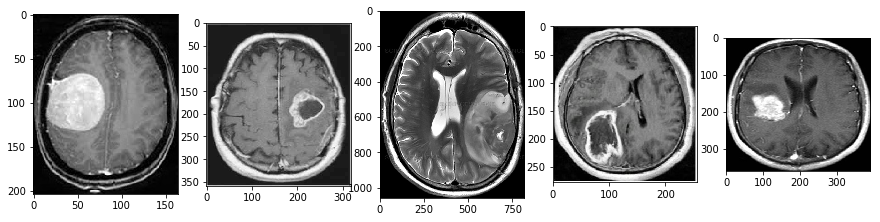

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(15,10))
i = 0
images = os.listdir(f'{RESULT_PATH}/no')
for n, image_name in enumerate(images):
    if n >= 5: 
        break
    img = cv2.imread(f'{RESULT_PATH}/{directory}/{image_name}')
    ax[n].imshow(img)
plt.show()  

## Split the data into subdirectories
Now we create train, validation and test directories with yes/no subdirectories:

In [7]:
if not os.path.exists("train"):
    os.makedirs("train")
    os.makedirs("train/yes")
    os.makedirs("train/no")

if not os.path.exists("test"):
    os.makedirs("test")
    os.makedirs("test/yes")
    os.makedirs("test/no")

if not os.path.exists("validation"):
    os.makedirs("validation")
    os.makedirs("validation/yes")
    os.makedirs("validation/no")

In [8]:
import shutil

for f in os.listdir(RESULT_PATH):
    images = os.listdir(f'{RESULT_PATH}/{f}')
    for n, image in enumerate(images):
        if n < 0.05 * len(images):
            shutil.copy(f'{RESULT_PATH}/{f}/{image}', f'test/{f}/{f + str(n)}.jpg')
        elif n < 0.8 * len(images):
            shutil.copy(f'{RESULT_PATH}/{f}/{image}', f'train/{f}/{f + str(n-round(0.05 * len(images)))}.jpg')
        else:
            shutil.copy(f'{RESULT_PATH}/{f}/{image}', f'validation/{f}/{f + str(n-round(0.8 * len(images)))}.jpg')

## Data augmentation
As we have only 253 images in our dataset we will need to use data augmentation.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# validation data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        'validation',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

Using TensorFlow backend.


Found 190 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


## First CNN model
Defining the model architecture:

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))  # filers, kernel size (keras example)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train and save the model:

In [11]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // 16,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800 // 16)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")




Epoch 1/10





125/125 [==============================] - 65s 521ms/step - loss: 0.6656 - acc: 0.6425 - val_loss: 0.4405 - val_acc: 0.8180
Epoch 2/10
125/125 [==============================] - 62s 493ms/step - loss: 0.4838 - acc: 0.7699 - val_loss: 0.3422 - val_acc: 0.8770
Epoch 3/10
125/125 [==============================] - 62s 496ms/step - loss: 0.4161 - acc: 0.8139 - val_loss: 0.3522 - val_acc: 0.8782
Epoch 4/10
125/125 [==============================] - 62s 496ms/step - loss: 0.3303 - acc: 0.8619 - val_loss: 0.3507 - val_acc: 0.8625
Epoch 5/10
125/125 [==============================] - 61s 487ms/step - loss: 0.2642 - acc: 0.8994 - val_loss: 0.3729 - val_acc: 0.8402
Epoch 6/10
125/125 [==============================] - 65s 521ms/step - loss: 0.2108 - acc: 0.9262 - val_loss: 0.4653 - val_acc: 0.8592
Epoch 7/10
125/125 [==============================] - 65s 522ms/step - loss: 0.1520 - acc: 0.9480 - val_loss: 0.5290 - val_acc: 0.8592
Epoch 8/10
125/125 [===========================

We can load the model with:

In [ ]:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Model performace:
Model overfits after first epoch

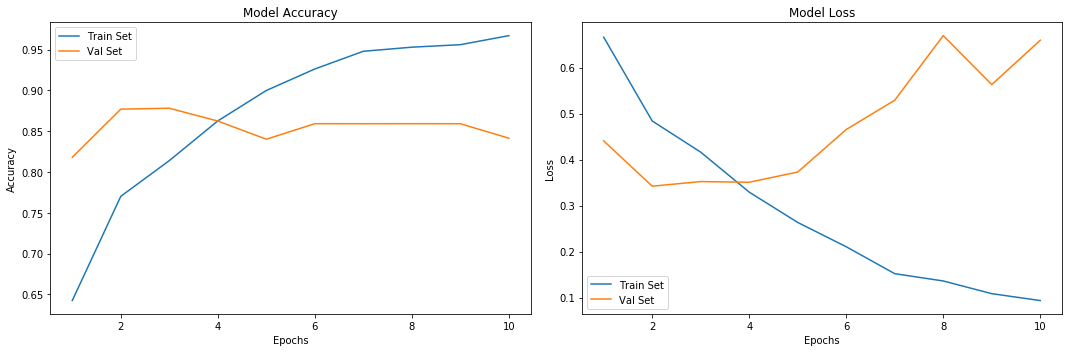

In [13]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Score on test data:

In [14]:
model.evaluate_generator(test_generator, 400)

[0.2175457204133272, 0.9230769276618958]

## Data simplification
As we're dealing with brain MRI's, we don't need RGB values - we can use gray images.

In [15]:
train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        color_mode="grayscale",
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = validation_datagen.flow_from_directory(
        'validation',
        target_size=(224, 224),
        color_mode="grayscale",
        batch_size=16,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        color_mode="grayscale",
        batch_size=16,
        class_mode='binary')

Found 190 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


## Second CNN model

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu'))  # filers, kernel size (keras example)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=500 // 16,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=200 // 16)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model2.h5")

Epoch 1/10
31/31 [==============================] - 15s 474ms/step - loss: 0.7058 - acc: 0.6019 - val_loss: 0.6635 - val_acc: 0.6533
Epoch 2/10
31/31 [==============================] - 14s 442ms/step - loss: 0.6655 - acc: 0.6492 - val_loss: 0.6208 - val_acc: 0.6933
Epoch 3/10
31/31 [==============================] - 13s 429ms/step - loss: 0.6137 - acc: 0.6884 - val_loss: 0.6338 - val_acc: 0.7133
Epoch 4/10
31/31 [==============================] - 14s 461ms/step - loss: 0.5866 - acc: 0.7215 - val_loss: 0.5890 - val_acc: 0.7133
Epoch 5/10
31/31 [==============================] - 14s 444ms/step - loss: 0.5129 - acc: 0.7713 - val_loss: 0.4729 - val_acc: 0.8333
Epoch 6/10
31/31 [==============================] - 13s 432ms/step - loss: 0.5389 - acc: 0.7684 - val_loss: 0.4750 - val_acc: 0.8267
Epoch 7/10
31/31 [==============================] - 14s 447ms/step - loss: 0.4826 - acc: 0.7987 - val_loss: 0.5422 - val_acc: 0.7733
Epoch 8/10
31/31 [==============================] - 14s 447ms/step - 

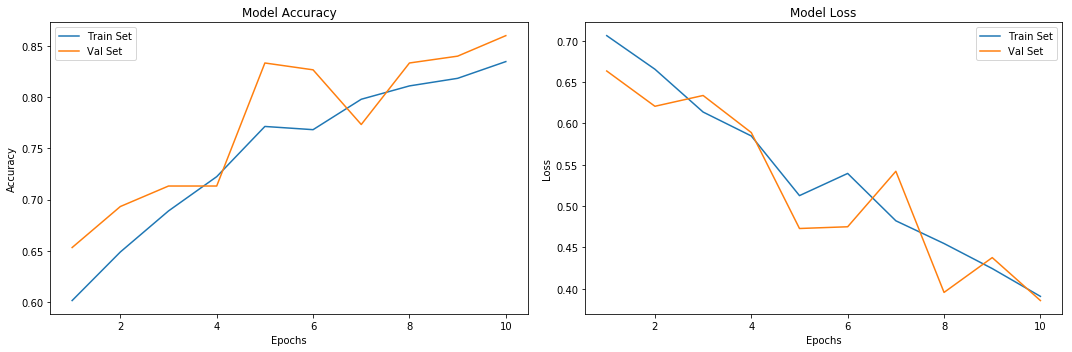

In [21]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Explanation 
We start by creating a lime explainer:

In [24]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

Now we can load a test image and create an explanation for it:

In [51]:
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import rgb_to_grayscale

img = load_img('test/yes/yes2.jpg', target_size=(224, 224))
img = img_to_array(img).astype('double')

def predict_fn(images):
    images = images[:,:,:,:1]
    return model.predict(images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=1, num_samples=1000, hide_color=0)

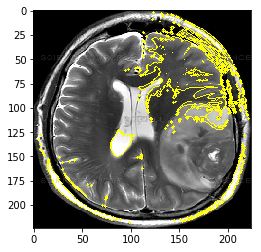

<Figure size 432x288 with 0 Axes>

In [52]:
from skimage.segmentation import mark_boundaries
from keras.preprocessing.image import array_to_img

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(array_to_img(temp), mask))
plt.show()
plt.savefig('explanation.png')

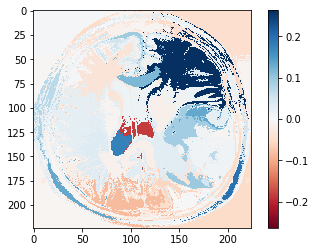

In [53]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.show()